<a href="https://colab.research.google.com/github/svg3982/CITO_2024/blob/main/cito_phantom_jaspersimone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/svg3982/CITO_2024

In [ ]:
!apt-get install -y ffmpeg



# -----Imports-----#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

class PhysicsSim:

    def __init__(self, positions, radii):

        self.nSpheres = len(positions)  # Amount of Spheres
        self.positions = positions  # Positions of all spheres
        self.radii = radii  #Radius for all spheres


    # Initialize masses and velocities of the spheres
    # temperature determines initial velocities of spheres, density determines mass of spheres
    def init(self, temperature, density):

        # Caclulate mass of spheres based on their volume and given density
        self.masses = density*(4/3)*np.pi*self.radii**3

        # Randomly set velocities according to Maxwell-Boltzmann distribution
        sigmas = np.sqrt(temperature / self.masses)
        self.velocities = np.zeros((self.nSpheres, 3))
        for i in range(self.nSpheres):
            self.velocities[i, :] = np.random.normal(0, sigmas[i], 3)

        self.velocities[:, 2] = 0




    # Moves spheres linearly for time dt
    def moveSpheres(self, dt):
        self.positions += self.velocities * dt
        self.collisionTimeArray -= dt

    # Get the indices of the next speheres to collide
    def getNextCollision(self):

        i = np.argmin(self.minCollisionTimes)
        j = np.argmin(self.collisionTimeArray[i, :])
        return i, j

    #Collides two spheres which changes their velocity
    def collide(self, i, j):

        # Calculate the direction of momentum transfer
        direction = self.positions[i, :] - self.positions[j, :]
        direction /= np.sqrt(np.dot(direction, direction))

        cm = 1 / self.masses[i] + 1 / self.masses[j]
        dv = self.velocities[i, :] - self.velocities[j, :]

        # Calculate the amount of momentum transferred
        dpAbs = -2 * np.dot(direction,  dv / cm)
        dp = direction * dpAbs

        # Change velocity based on momentum transferred
        if i != 0:
          self.velocities[i] += dp / self.masses[i]

        if j != 0:
          self.velocities[j] -= dp / self.masses[j]

    # Calculates when sphere i will collide with any other sphere assuming current velocities remain constant
    def getCollisionTimes(self, i):



        RSquared = (self.radii[i] + self.radii)**2
        dx = self.positions[i, :] - self.positions
        dv = self.velocities[i, :] - self.velocities
        dxdx = np.sum(dx * dx, axis=1)
        dvdv = np.sum(dv * dv, axis=1)
        dxdv = np.sum(dx * dv, axis=1)

        D = dxdv**2 - dvdv*(dxdx - RSquared)
        collisionTimes = np.zeros(self.nSpheres)
        willCollide = (D > 0) * (dvdv > 0)

        # Only a small subset of sphere combinations will collide, this calculates when that will happen
        collisionTimes[willCollide] = (-np.sqrt(D[willCollide]) - dxdv[willCollide]) / dvdv[willCollide]

        # For the other spheres we set the collision time to a very high number
        collisionTimes[willCollide == False] = 9999

        # collisions that would have happened in the past are ignored
        collisionTimes[collisionTimes < 0] = 9999

        self.collisionTimeArray[i, :] = collisionTimes
        self.collisionTimeArray[:, i] = collisionTimes
        self.minCollisionTimes[i] = np.amin(collisionTimes)

        return collisionTimes

    # Initializes array that keeps track of when every combination of spheres will collide
    def initCollisionTimeArray(self):

        self.collisionTimeArray = np.zeros((self.nSpheres, self.nSpheres))
        self.minCollisionTimes = np.zeros(self.nSpheres)

        for i in range(self.nSpheres):
            self.getCollisionTimes(i)

    # Runs the simulation for maxTime seconds
    def run(self, maxTime, timesteps):

        self.positionsLog = np.zeros((timesteps+1, self.nSpheres, 3))
        self.positionsLog[0, :, :] = np.copy(self.positions)
        self.initCollisionTimeArray()
        saveTime = maxTime / timesteps
        nextStop = saveTime
        iter = 0
        currentTime = 0

        while (iter < timesteps):

            i, j = self.getNextCollision()
            dt = self.collisionTimeArray[i, j]

            if dt >= nextStop - currentTime:
                iter += 1
                self.moveSpheres(nextStop - currentTime)
                self.positionsLog[iter, :, :] = np.copy(self.positions)
                currentTime = nextStop
                nextStop += saveTime
                continue

            print(f"Collision at time {currentTime+dt}")
            self.moveSpheres(dt)

            self.collide(i, j)

            self.getCollisionTimes(i)
            self.getCollisionTimes(j)

            currentTime += dt

        return self.positionsLog


# def sphereDrawer(positions, radii, size, z, resolution):

#     radiiSeen = radii ** 2 - (positions[:, 2] - z) ** 2
#     radiiSeen[radiiSeen < 0] = 0
#     radiiSeen = np.sqrt(radiiSeen)

#     image = np.zeros((resolution, resolution))
#     for x in range(resolution):
#         X = size * (x + 0.5) / resolution - 0.5 * size

#         for y in range(resolution):
#             Y = size * (y + 0.5) / resolution - 0.5 * size

#             dr = positions - np.array([X, Y, z])

#             if np.sum(np.sum(dr * dr, axis=1) < radiiSeen**2) > 0:
#                 image[x, y] = 1

#     plt.imshow(image, cmap="gray")

#     plt.show()








Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


[[-3.24100882e-01 -8.30088878e-02  9.35006851e-01  5.00000000e-01]
 [ 1.81130886e-02  5.50902290e-01  1.66479665e-01  4.48800021e-01]
 [-4.23981181e-01 -3.61281406e-01  2.87323516e-02  4.42968317e-01]
 [ 5.04740751e-01 -3.03633150e-01  5.94423782e-01  4.10970021e-01]
 [ 2.57637313e-02  6.80984569e-01  9.82057428e-01  3.18528244e-01]
 [ 5.57201195e-01  3.63513533e-01  5.70238285e-01  2.50307665e-01]
 [-4.81048682e-01  6.25984842e-01  7.49838971e-01  2.10528748e-01]
 [-7.17452617e-02 -7.37751224e-01  9.35552133e-01  2.01691658e-01]
 [ 5.08248514e-01  1.80687711e-01  9.98654626e-01  2.18053528e-01]
 [ 7.13602270e-01  3.82003287e-01  3.42362817e-03  1.90583722e-01]
 [-7.49362450e-01  1.41884622e-02  4.04615466e-01  1.80039474e-01]
 [ 1.02166306e-01 -6.22124301e-01  3.09933704e-01  1.75917874e-01]
 [ 3.77940016e-01  7.49847088e-01  6.55659852e-01  1.60292127e-01]
 [ 6.24932071e-01  8.51329549e-02  2.17488644e-01  1.43705682e-01]
 [ 1.74258203e-01 -8.41258103e-01  8.90960200e-02  1.40883525e

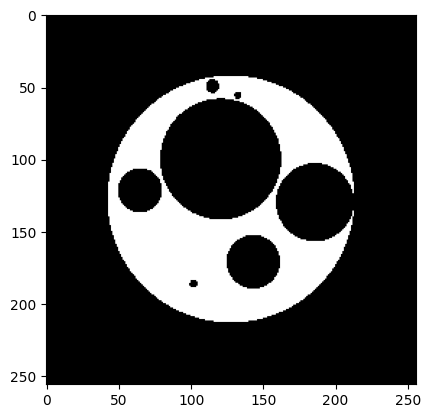

In [ ]:
#VERSION 1.1

import numpy as np
import matplotlib.pyplot as plt

phantom_size = [256,256]

#constants as input for function
maximum_height = 256
n_voids = 100
r_c = 1
r_max = 0.5
rng = np.random.default_rng(seed=35)

#old
'''def euc_dist(current_x, current_y, current_z,other_points):
    full_list = [] #we keep this list to calculate overlap with voids later
    closest_void = float('inf')
    for j in other_points:
        x_j, y_j, z_j,r_j = j[0],j[1],j[2],j[3]
        current_dist = np.linalg.norm([current_x,current_y,current_z]-[x_j,y_j,z_j])
        full_list.append(current_dist)
        #term 2 in equation (1), page 4. Keep min(d(a,b) - r_j) over all j's
        if (current_dist - r_j) < closest_void:
            closest_void = (current_dist - r_j)
    return full_list,closest_void'''
def euc_dist(current_x, current_y, current_z, other_points):
    full_list = []
    closest_void = float('inf')
    #print('other_points',len(other_points))
    if len(other_points) == 0:
        return full_list, closest_void
    for j in other_points:
        x_j, y_j, z_j,r_j = j[0],j[1],j[2],j[3]
        current_dist = np.linalg.norm(np.array([current_x,current_y,current_z])-np.array([x_j,y_j,z_j]))
        full_list.append(current_dist)
        #term 2 in equation (1), page 4. Keep min(d(a,b) - r_j) over all j's
        if (current_dist - r_j) < closest_void:
            closest_void = (current_dist - r_j)
    return full_list,closest_void

def add_trial_points(kill_list, phantoms, trials):
    counter = 0
    while counter < len(kill_list):
        x_i = rng.uniform(-1,1)
        #pick RANDOM y
        y_i = rng.uniform(-1,1)
        #pick RANDOM z
        z_i = rng.uniform(0,1)
        #for i,point in enumerate(kill_list):
        _, closest_void = euc_dist(x_i,y_i,z_i,phantoms) #[3] trial_list
        #pick radius r_i from equation (1) in paper
        if ((x_i**2 + y_i**2)**0.5) > r_c:
            continue
        r_i = min((1-(x_i**2 + y_i**2)**0.5),closest_void,r_max)
        if r_i < 0:
            continue
        if abs(z_i) <= maximum_height:
            #add to trial_list
            trials[kill_list[counter]] = np.array([x_i, y_i, z_i, r_i])
            counter += 1
        else:
            continue
    #print('trials in add_method',len(trials))
    return trials

def update_trial_list(trials):
  #take the largest void (sort by r_i, 4th column)
  trials[trials[:,3].argsort()]
  #when there are multiple, take RANDOM
  largest_index = np.argmax(trials[:,3])
  largest_void = np.asarray(trials[largest_index])
  trials = np.delete(trials,largest_index,axis=0) #remove from trial points
  kills = kill_points(largest_void, trials)
  return trials, largest_void, kills

def kill_points(largest, trials):
  largest_radius = largest[3]
  distances,_ = euc_dist(largest[0],largest[1],largest[2],trials)
  kill_list = []
  for count,j in enumerate(trials):
    distance = distances[count]
    trial_radius = j[3]
    if distance < (largest_radius + trial_radius):
      kill_list.append(count)
    else:
      continue
  return kill_list

#fill all pixels outside cylinder with 1
def sphereDrawer(positions, radii, size, z, resolution):

    radiiSeen = radii ** 2 - (positions[:, 2] - z) ** 2
    radiiSeen[radiiSeen < 0] = 0
    radiiSeen = np.sqrt(radiiSeen)

    image = np.zeros((resolution, resolution))
    for x in range(resolution):
        X = size * (x + 0.5) / resolution - 0.5 * size

        for y in range(resolution):
            Y = size * (y + 0.5) / resolution - 0.5 * size

            if X**2 + Y**2 > 1:
                image[x,y] = 1
                continue

            dr = positions - np.array([X, Y, z])

            if np.sum(np.sum(dr * dr, axis=1) < radiiSeen**2) > 0:
                image[x, y] = 1

    plt.imshow(image, cmap="Greys")

    plt.show()

if __name__ == "__main__":
    phantom_matrix = []
    trial_list = np.zeros([n_voids,4],dtype=float) #x coord, y coord, z coord, radius
    kills = np.arange(0,100,1)
    for n in range(n_voids):
        trial_list = add_trial_points(kills, phantom_matrix, trial_list)
        trial_list, largest_void, kills = update_trial_list(trial_list)
        phantom_matrix.append(largest_void)
    phantom_matrix = np.asarray(phantom_matrix,dtype=float)
    print(phantom_matrix,'voids')
    sphereDrawer(phantom_matrix[:,0:3],phantom_matrix[:,3],size=3,z=1,resolution=maximum_height)

[[-0.0042648  -0.01276033  0.50022619  0.5       ]
 [ 0.17927956  0.72255349  0.45572751  0.2555373 ]
 [-0.73162425  0.17543584  0.88979034  0.24763587]
 [ 0.72634829 -0.09413312  0.64571841  0.23513062]
 [-0.21349751 -0.73486676  0.03743241  0.23474819]
 [ 0.36797826 -0.65013592  0.02509094  0.23811417]
 [-0.63403839 -0.4303748   0.29194082  0.23369253]
 [ 0.69219002  0.3904238   0.18382068  0.20529391]
 [-0.54267466  0.5890114   0.31908295  0.19910662]
 [ 0.70998343 -0.45402806  0.48907639  0.12513619]
 [-0.18435369  0.5831341   0.25130696  0.1225128 ]
 [-0.23071053  0.85969299  0.77350303  0.10988799]
 [-0.89949372 -0.12737116  0.26741642  0.09153296]
 [ 0.07971462 -0.86002639  0.79283844  0.08405941]
 [ 0.50585854 -0.36667871  0.60216828  0.07709839]] voids
Collision at time 2.966413279224256e-17
Collision at time 0.004985607389943332
Collision at time 0.00531453172736932
Collision at time 0.015643998550875737
Collision at time 0.02368056202018609
Collision at time 0.03039964267896

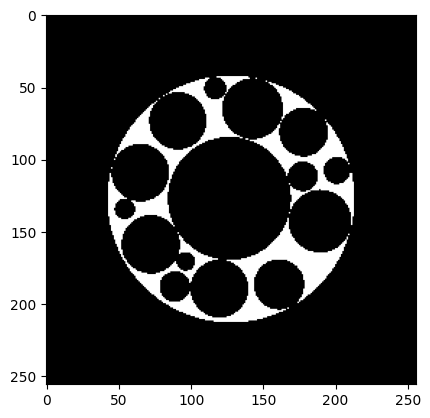

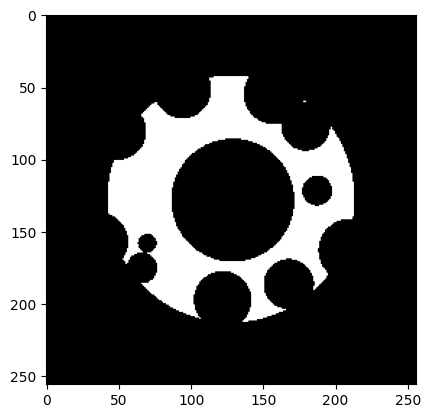

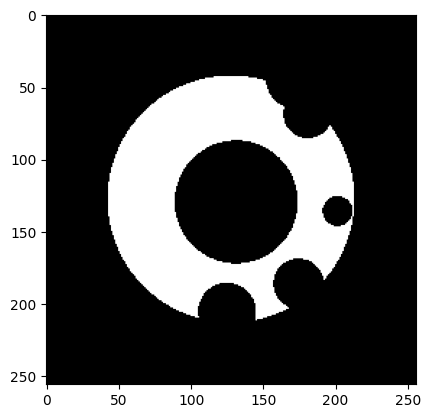

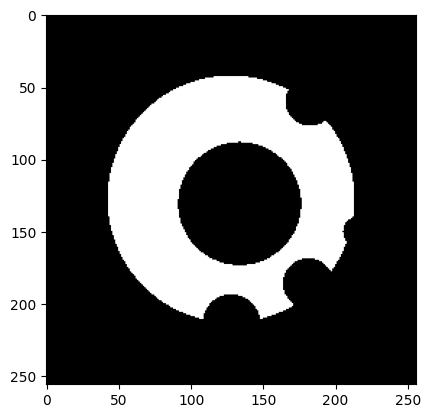

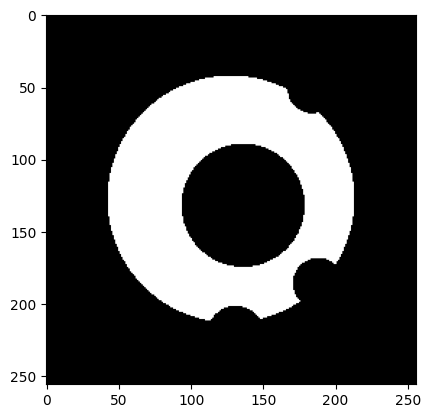

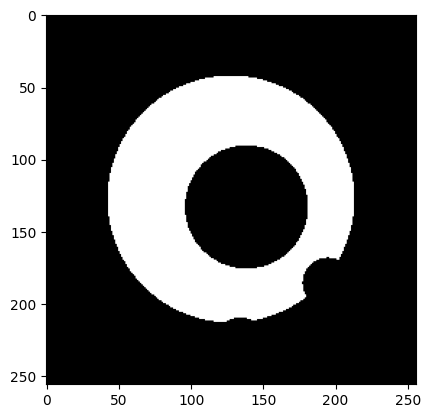

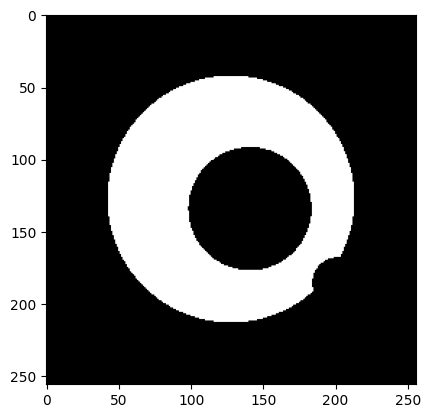

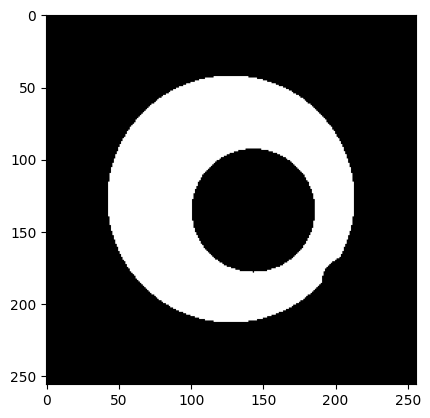

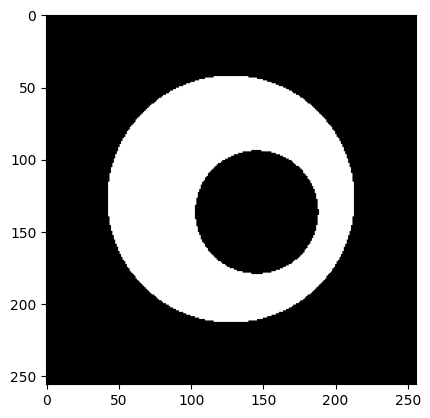

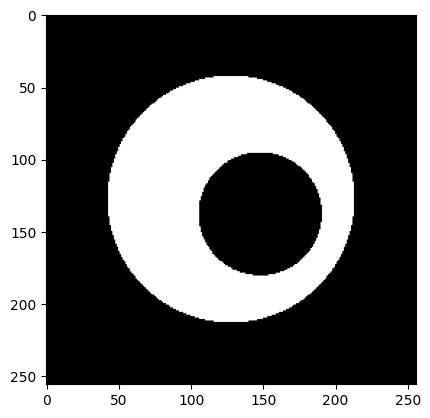

In [ ]:
#VERSION 1.2

import numpy as np
import matplotlib.pyplot as plt

phantom_size = [256,256]

#constants as input for function
#maximum_height = 256
n_voids = 15
n_trialpoints = 100
r_c = 1
r_max = 0.5
rng = np.random.default_rng(seed=4)

#old
'''def euc_dist(current_x, current_y, current_z,other_points):
    full_list = [] #we keep this list to calculate overlap with voids later
    closest_void = float('inf')
    for j in other_points:
        x_j, y_j, z_j,r_j = j[0],j[1],j[2],j[3]
        current_dist = np.linalg.norm([current_x,current_y,current_z]-[x_j,y_j,z_j])
        full_list.append(current_dist)
        #term 2 in equation (1), page 4. Keep min(d(a,b) - r_j) over all j's
        if (current_dist - r_j) < closest_void:
            closest_void = (current_dist - r_j)
    return full_list,closest_void'''
def euc_dist(current_x, current_y, current_z, other_points):
    full_list = []
    closest_void = float('inf')
    #print('other_points',len(other_points))
    if len(other_points) == 0:
        return full_list, closest_void
    for j in other_points:
        x_j, y_j,r_j = j[0],j[1],j[3]
        current_dist = np.linalg.norm(np.array([current_x,current_y])-np.array([x_j,y_j]))
        full_list.append(current_dist)
        #term 2 in equation (1), page 4. Keep min(d(a,b) - r_j) over all j's
        if (current_dist - r_j) < closest_void:
            closest_void = (current_dist - r_j)
    return full_list,closest_void

def add_trial_points(kill_list, phantoms, trials):
    counter = 0
    while counter < len(kill_list):
        x_i = rng.uniform(-1,1)
        #pick RANDOM y
        y_i = rng.uniform(-1,1)
        #pick RANDOM z
        z_i = rng.uniform(0,1)
        #for i,point in enumerate(kill_list):
        _, closest_void = euc_dist(x_i,y_i,z_i,phantoms) #[3] trial_list
        #pick radius r_i from equation (1) in paper
        if ((x_i**2 + y_i**2)**0.5) > r_c:
            continue
        r_i = min((1-(x_i**2 + y_i**2)**0.5),closest_void,r_max)
        if r_i < 0:
            continue
        trials[kill_list[counter]] = np.array([x_i, y_i, z_i, r_i])
        counter += 1
    #print('trials in add_method',len(trials))
    return trials

def update_trial_list(trials):
  #take the largest void (sort by r_i, 4th column)
  trials[trials[:,3].argsort()]
  #when there are multiple, take RANDOM
  largest_index = np.argmax(trials[:,3])
  largest_void = np.asarray(trials[largest_index])
  trials = np.delete(trials,largest_index,axis=0) #remove from trial points
  kills = kill_points(largest_void, trials)
  return trials, largest_void, kills

def kill_points(largest, trials):
  largest_radius = largest[3]
  distances,_ = euc_dist(largest[0],largest[1],largest[2],trials)
  kill_list = []
  for count,j in enumerate(trials):
    distance = distances[count]
    trial_radius = j[3]
    if distance < (largest_radius + trial_radius):
      kill_list.append(count)
    else:
      continue
  return kill_list

#fill all pixels outside cylinder with 1
def sphereDrawer(positions, radii, size, z, resolution):

    image = np.zeros((resolution, resolution))
    for x in range(resolution):
        X = size * (x + 0.5) / resolution - 0.5 * size

        for y in range(resolution):
            Y = size * (y + 0.5) / resolution - 0.5 * size

            if X**2 + Y**2 > 1:
                image[x,y] = 1
                continue

            dr = positions[:,0:2] - np.array([X, Y])

            if np.sum(np.sum(dr * dr, axis=1) < radii**2) > 0:
                image[x, y] = 1

    plt.imshow(image, cmap="Greys")

    plt.show()

if __name__ == "__main__":
    phantom_matrix = []
    trial_list = np.zeros([n_trialpoints,4],dtype=float) #x coord, y coord, z coord, radius
    kills = np.arange(0,n_trialpoints,1)
    for n in range(n_voids):
        trial_list = add_trial_points(kills, phantom_matrix, trial_list)
        trial_list, largest_void, kills = update_trial_list(trial_list)
        phantom_matrix.append(largest_void)
    phantom_matrix = np.asarray(phantom_matrix,dtype=float)
    print(phantom_matrix,'voids')

    positions = phantom_matrix[:,0:3]
    positions[:,2] = 0
    radii = phantom_matrix[:,3]

    sim = PhysicsSim(positions, radii)

    sim.init(0.02, 1)
    positionLog = sim.run(3, 10)

    for i in range(10):
      sphereDrawer(positionLog[i],radii,size=3,z=1,resolution=maximum_height)

# New Section